## Supplementary: Baseline Model Interpretation with SHAP

#### Rishane Dassanayake

## Introduction

#### What is the purpose of this notebook?
To find out why my models are misclassifying certain points

#### How? 
1. Separate correctly classified and misclassified points
2. Look at SHAP values for each of tp, fp, tn, fn for the two best-performing models
3. Identify features that are creating misclassifications

> NOTE: This notebook does not contain in-depth markdown commentary. This is because, given the inherent limitations of standard ML models in allowing for causal interpretations of model outputs, identifying why these models are misclassifying points would only improve the prediction accuracy of these models but not help with investigating the causal effect of social pressure on voting. Therefore, I decided to shift my attention to fleshing out the causal forest model instead. However, I have decided to include this notebook as supplementary material. 

## Basic Setup

In [54]:
# import basic libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from joblib import dump, load

# import util functions
import sys
sys.path.append('../utils/')
import capstone_utils as u

# import model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# import evaluation libraries 
from sklearn.tree import plot_tree
import shap 
import lime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

In [80]:
# import original data
data_original = pd.read_csv('~/Desktop/social_engineered.csv', low_memory=False, index_col=0)
display(data_original.head())

,sex,g2000,g2002,p2000,p2002,p2004,voted,votedav,dem,hh_size,...,less9thgrade,highschool,age,treatment_civic duty,treatment_control,treatment_hawthorne,treatment_neighbors,treatment_self,percent_under18years,percent_18to64years
0,1,1,1,0,1,0,0,0,43,1,...,2.2,37.2,88,0,1,0,0,0,19.9,64.6
1,0,1,1,1,1,1,1,0,1,2,...,2.2,37.2,53,0,1,0,0,0,19.9,64.6
2,0,1,1,0,1,0,0,0,0,2,...,2.2,37.2,79,0,0,0,1,0,19.9,64.6
3,1,1,1,0,0,1,0,0,6,4,...,2.2,37.2,53,0,1,0,0,0,19.9,64.6
4,0,0,1,0,0,0,0,0,9,3,...,2.2,37.2,22,0,0,1,0,0,19.9,64.6


In [306]:
# import split data
X_train = pd.read_csv('~/Desktop/cap_data/social_X_train.csv', index_col=0)
X_test = pd.read_csv('~/Desktop/cap_data/social_X_test.csv', index_col=0)
y_train = pd.read_csv('~/Desktop/cap_data/social_y_train.csv', index_col=0)
y_test = pd.read_csv('~/Desktop/cap_data/social_y_test.csv', index_col=0)

In [307]:
# import smote data
X_train_lr6 = pd.read_csv('~/Desktop/cap_data/social_X_train_lr6.csv', index_col=0)
X_test_lr6 = pd.read_csv('~/Desktop/cap_data/social_X_test_lr6.csv', index_col=0)
y_train_smote = pd.read_csv('~/Desktop/cap_data/social_y_train_smote.csv', index_col=0)

In [92]:
# print data shapes 
print(data_original.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_train_lr6.shape)
print(X_test_lr6.shape)
print(y_train_smote.shape)

(344084, 35)
(247740, 32)
(61935, 32)
(247740, 1)
(61935, 1)
(338958, 32)
(61935, 32)
(338958, 1)


In [65]:
# load in models
rf_balanced = load('../models/rf_balanced.pkl')
gbc = load('../models/gbc.pkl')

In [305]:
X_train.columns

Index(['sex', 'g2000', 'g2002', 'p2000', 'p2002', 'p2004', 'dem', 'hh_size',
       'totalpopulation_estimate', 'percent_female', 'median_age',
       'percent_65yearsandover', 'percent_white', 'percent_black',
       'percent_amindian_alaskan', 'percent_asian', 'percent_nativeandother',
       'percent_other_nativeandother', 'percent_hispanicorlatino',
       'percent_race_other', 'median_income', 'unemploy_16', 'bach_orhigher',
       'less9thgrade', 'highschool', 'age', 'treatment_civic duty',
       'treatment_hawthorne', 'treatment_neighbors', 'treatment_self',
       'percent_under18years', 'percent_18to64years', 'treated'],
      dtype='object')

## Overview of all datapoints using SHAP 

#### Balanced Random Forest

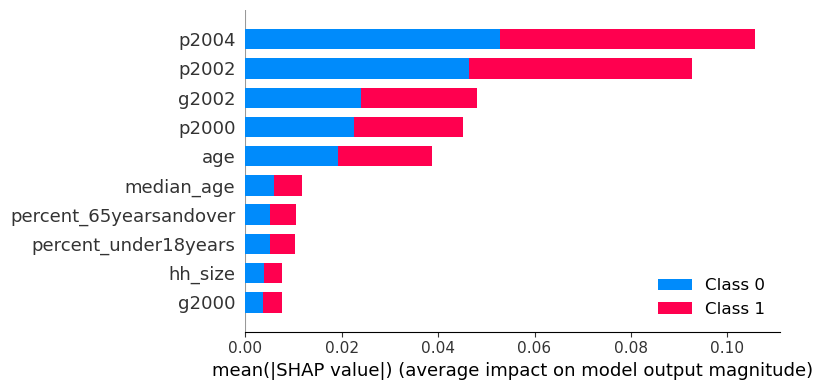

In [348]:
shap_calculator(10, rf_balanced, X_test)

#### Gradient Boosting Classifier

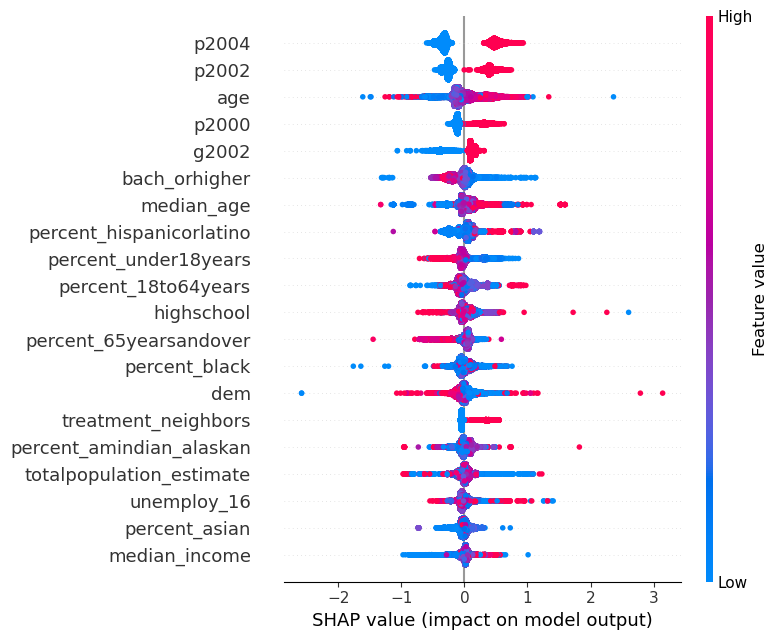

In [350]:
shap_calculator(20, gbc, X_test)

## Evaluating misclassified points

For each of my two models, I use the following process to understand why the model is misclassifying points
- **Feature Importance**: Compare the feature importance (as measured by position on the y-axis) across all 4 possibilities, especially comparing correctly classified vs. misclassified points. A feature that significantly impacts incorrect classifications but not correct ones is a cause for concern. 
- **Spread of SHAP values (where relevant)**: Compare the spread of SHAP values where possible. Broad distributions in incorrectly classified points for a feature suggests varied impact. Narrow distributions show that the model consistently misinterprets the feature at certain values.
- **Color patterns**: If coloring in misclassified plots is consistent and coloring in correctly classified plots is mixed, this may indicate that extreme values are contributing to errors. Suddent changes in the color distribution between misclassified and correctly classified plots for the same feature indicate the value ranges where the model fails. 

#### Extracting misclassified points

In [463]:
# extract false negatives for all models
rf_balanced_fn = get_classification_subset('false negative', rf_balanced, X_test, y_test)
gbc_fn = get_classification_subset('false negative', gbc, X_test, y_test)

In [464]:
# extract true negatives for all models
rf_balanced_tn = get_classification_subset('true negative', rf_balanced, X_test, y_test)
gbc_tn = get_classification_subset('true negative', gbc, X_test, y_test)

In [465]:
# extract false positives for all models 
rf_balanced_fp = get_classification_subset('false positive', rf_balanced, X_test, y_test)
gbc_fp = get_classification_subset('false positive', gbc, X_test, y_test)

In [466]:
# extract true positives for all models
rf_balanced_tp = get_classification_subset('true positive', rf_balanced, X_test, y_test)
gbc_tp = get_classification_subset('true positive', gbc, X_test, y_test)

In [467]:
# sense-check the output
row_calculator('rf_balanced', rf_balanced_tn, rf_balanced_fn, rf_balanced_tp, rf_balanced_fp)

Number of true negatives in rf_balanced: 24830
Number of false negatives in rf_balanced: 6316
Number of true positives in rf_balanced: 13249
Number of false positives in rf_balanced: 17540
Total number of rows = 61935


In [468]:
row_calculator('gbc', gbc_tn, gbc_fn, gbc_tp, gbc_fp)

Number of true negatives in gbc: 38396
Number of false negatives in gbc: 13624
Number of true positives in gbc: 5941
Number of false positives in gbc: 3974
Total number of rows = 61935


### Balanced Random Forest

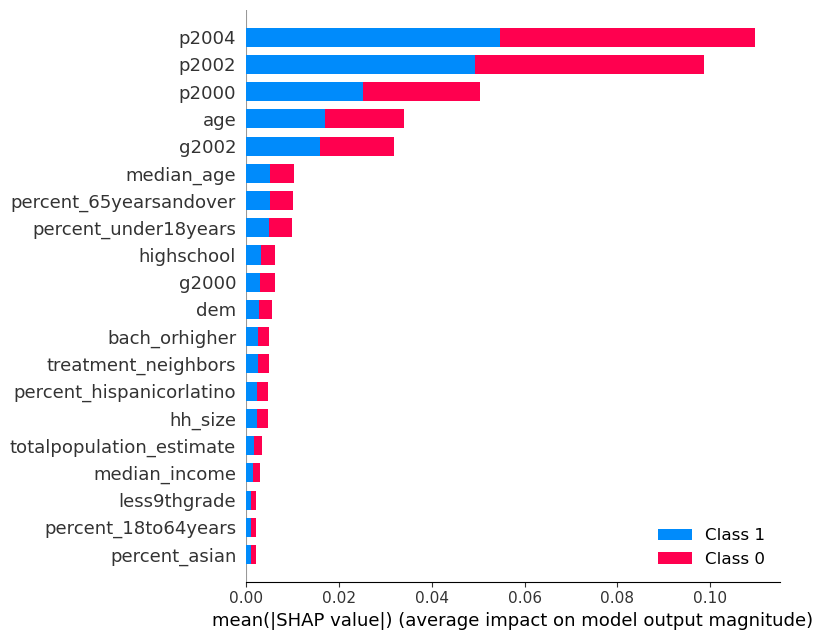

In [511]:
# true positives
shap_visualiser(20, rf_balanced, rf_balanced_tp)

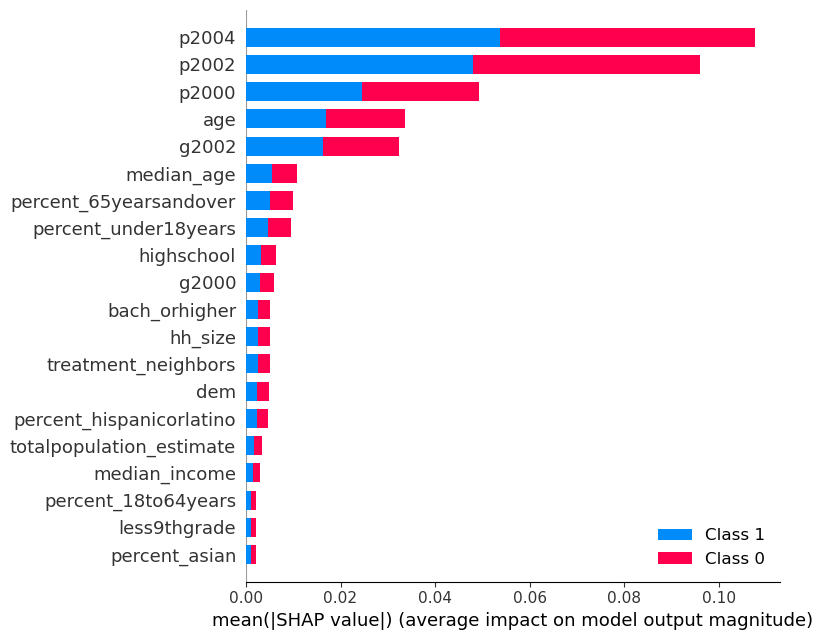

In [512]:
# false positives
shap_visualiser(20, rf_balanced, rf_balanced_fp)

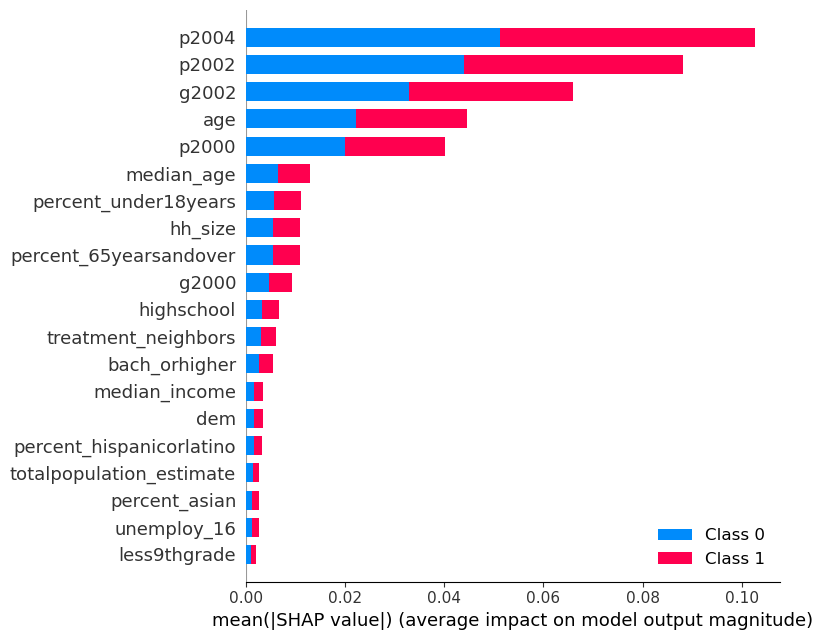

In [513]:
# true negatives
shap_visualiser(20, rf_balanced, rf_balanced_tn)

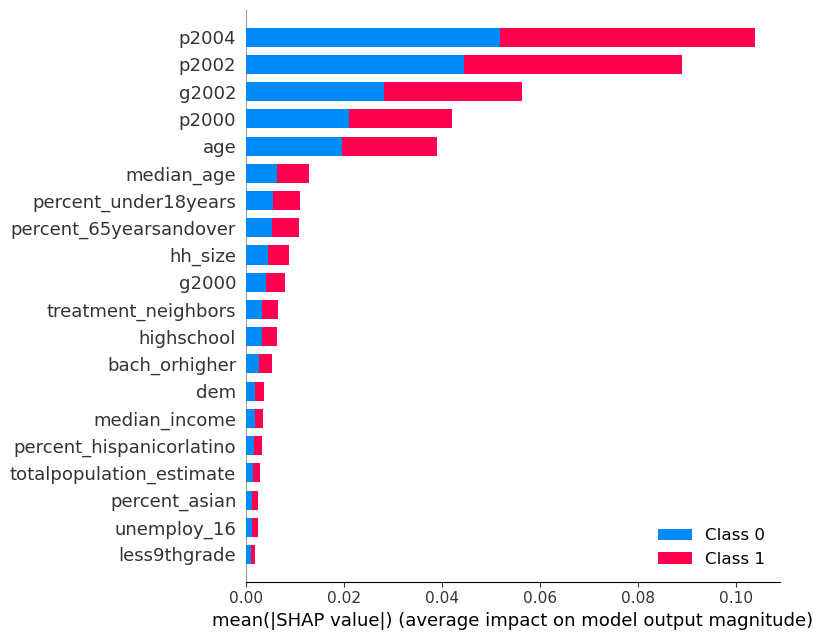

In [514]:
# false negatives
shap_visualiser(20, rf_balanced, rf_balanced_fn)

In [530]:
calculate_global_shap(rf_balanced, rf_balanced_tp, rf_balanced_fp, rf_balanced_tn, rf_balanced_fn, is_linear=False)

,true positive SHAP,false positive SHAP,true negative SHAP,false negative SHAP
sex,-6.195622e-18,-2.236952e-17,-1.095059e-16,-9.865435e-17
g2000,1.788196e-14,1.787101e-14,2.152618e-14,2.049082e-14
g2002,6.112558e-14,6.225923e-14,8.270641e-14,7.702476e-14
p2000,8.159836e-14,8.062257e-14,6.807575e-14,7.118438e-14
p2002,1.888906e-13,1.878341e-13,1.672863e-13,1.718608e-13
p2004,1.535334e-13,1.528083e-13,1.427886e-13,1.457567e-13
dem,-3.356283e-16,-3.417947e-17,4.000113e-16,2.862971e-16
hh_size,2.251378e-14,2.253265e-14,2.685796e-14,2.524936e-14
totalpopulation_estimate,-2.333040e-15,-2.301192e-15,-1.895145e-15,-1.957120e-15
percent_female,-1.766707e-16,-3.078152e-16,-7.399951e-16,-7.301492e-16


### Gradient Boosting Classifier

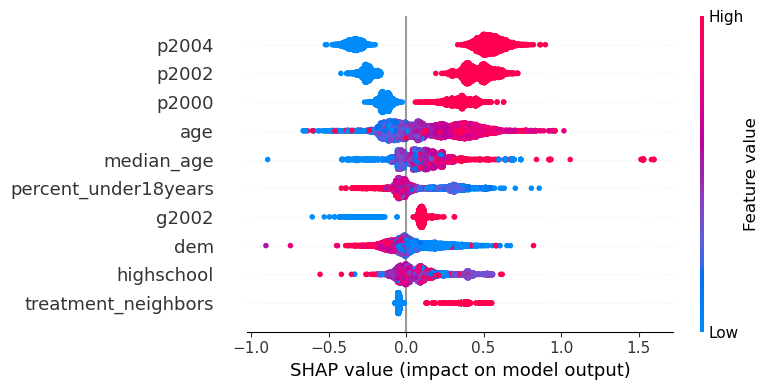

In [531]:
# true positives
shap_visualiser(10, gbc, gbc_tp)

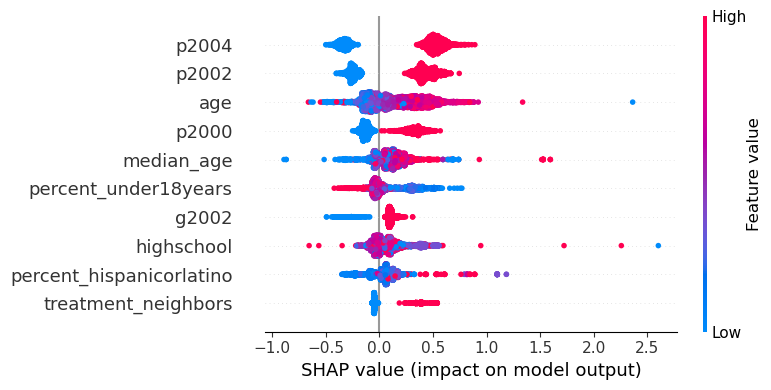

In [532]:
# false positives
shap_visualiser(10, gbc, gbc_fp)

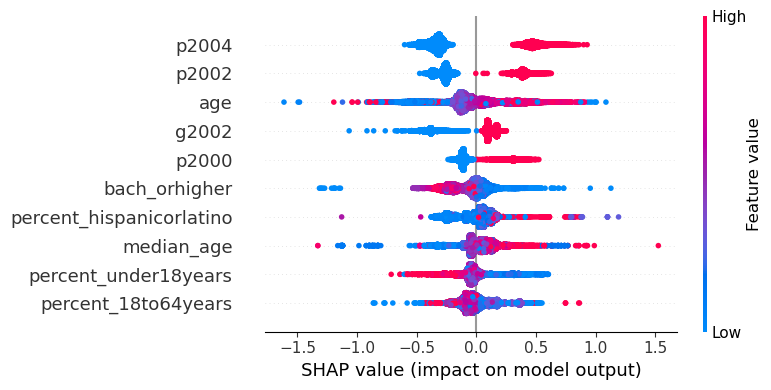

In [533]:
# true negatives
shap_visualiser(10, gbc, gbc_tn)

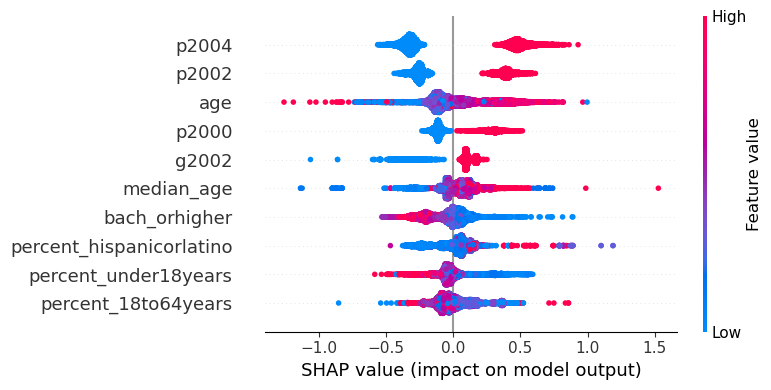

In [534]:
# false negatives
shap_visualiser(10, gbc, gbc_fn)

## Appendix

### Function: Calculating global SHAP values

In [529]:
def calculate_global_shap(model, tp, fp, tn, fn, is_linear):
    if is_linear:
        # If linear, aggregate data and use Independent masker
        pooled_data = pd.concat([tp, fp, tn, fn])
        masker = shap.maskers.Independent(data=pooled_data)
        explainer = shap.LinearExplainer(model, masker)
    else:
        # Otherwise, use a general explainer (TreeExplainer is assumed here for tree-based models)
        explainer = shap.TreeExplainer(model)
    
    def get_mean_shap_values(data):
        shap_values = explainer.shap_values(data)
        if isinstance(shap_values, list):
            # If shap_values is a list (multi-output), average across all outputs
            return np.mean([np.mean(vals, axis=0) for vals in shap_values], axis=0)
        else:
            # Otherwise, compute mean directly
            return np.mean(shap_values, axis=0)
    
    # Calculate mean SHAP values for each data set
    shap_values_tp = get_mean_shap_values(tp)
    shap_values_fp = get_mean_shap_values(fp)
    shap_values_tn = get_mean_shap_values(tn)
    shap_values_fn = get_mean_shap_values(fn)
    
    # Extract feature names from one of the data sets (assuming all have the same features)
    feature_names = tp.columns
    
    # Create a DataFrame to hold the SHAP values
    df_shap = pd.DataFrame({
        'true positive SHAP': pd.Series(shap_values_tp, index=feature_names),
        'false positive SHAP': pd.Series(shap_values_fp, index=feature_names),
        'true negative SHAP': pd.Series(shap_values_tn, index=feature_names),
        'false negative SHAP': pd.Series(shap_values_fn, index=feature_names)
    })
    
    return df_shap


### Function: Visualising global SHAP values

In [509]:
def shap_visualiser(num_features, model, test_set, linear=False):
    if linear==True:
        masker = shap.maskers.Independent(data = test_set)
        lin_explainer = shap.LinearExplainer(model, masker)
        lin_shap_values = lin_explainer.shap_values(test_set)
        lin_summary_plot = shap.summary_plot(lin_shap_values, test_set, feature_names = test_set.columns, max_display=num_features, plot_size=0.25)
        return lin_summary_plot
    else:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(test_set)
        summary_plot = shap.summary_plot(shap_values, test_set, feature_names = test_set.columns, max_display=num_features, plot_size=0.25)
        return summary_plot

### Function: Extract True/False Positives/Negatives

In [226]:
def get_classification_subset(confusion_label, model, x_test, y_true):
    """
    Returns the subset of X_test corresponding to true positives, true negatives,
    false positives, or false negatives.

    Args:
    - confusion_label (str): One of 'true_positive', 'true_negative', 'false_positive', 'false_negative'.
    - model: Trained machine learning model which supports 'predict' method.
    - X_test (DataFrame): Test features dataset.
    - y_true (array or series): Actual true labels. This is usually your y_test set.

    Returns:
    - DataFrame: A subset of X_test corresponding to the specified confusion label.
    """

    # Predict the outcomes
    y_pred = pd.Series(model.predict(x_test))

    # Ensure y_true is a Series
    y_true = y_true.squeeze().reset_index(drop=True)

    # Ensure X_test index is reset
    x_test = x_test.reset_index(drop=True)
    
    # Define conditions for each type of confusion matrix outcome
    conditions = {
        'true positive': (y_true == 1) & (y_pred == 1),
        'true negative': (y_true == 0) & (y_pred == 0),
        'false positive': (y_true == 0) & (y_pred == 1),
        'false negative': (y_true == 1) & (y_pred == 0)
    }
    
    # Validate input
    if confusion_label not in conditions:
        raise ValueError("confusion_label must be one of 'true positive', 'true negative', 'false positive', 'false negative'")

    
    # Apply the appropriate condition
    condition = conditions[confusion_label]
    return x_test[condition]

In [227]:
# test case
get_classification_subset('false positive', logreg_smote, X_test_lr6, y_test)

,sex,g2000,g2002,p2000,p2002,p2004,dem,hh_size,totalpopulation_estimate,percent_female,...,bach_orhigher,less9thgrade,highschool,age,treatment_civic duty,treatment_hawthorne,treatment_neighbors,treatment_self,percent_under18years,percent_18to64years
3,-0.873488,-2.244488,0.481488,-0.534865,1.325295,1.278389,-0.569479,1.168880,-1.055797,1.180820,...,1.272248,-0.513739,-1.261125,-2.021682,-0.306166,-0.306678,-0.309886,-0.308104,0.425726,0.536356
6,1.144835,-2.244488,0.481488,1.869632,1.325295,1.278389,-0.716459,2.472494,0.397110,0.418215,...,-0.002147,-0.513739,0.038402,0.537513,-0.306166,-0.306678,-0.309886,-0.308104,0.455850,-0.716698
18,-0.873488,-2.244488,0.481488,1.869632,-0.754549,1.278389,-0.765452,-0.134735,0.403275,-0.903635,...,0.248553,-0.285871,-0.364899,0.466425,-0.306166,-0.306678,-0.309886,-0.308104,1.118596,-0.138365
22,1.144835,0.445536,0.481488,-0.534865,1.325295,-0.782234,-1.059410,-0.134735,2.135636,0.265694,...,1.105114,-0.001037,-1.093082,-0.386640,-0.306166,-0.306678,-0.309886,-0.308104,0.546225,0.954040
25,1.144835,-2.244488,0.481488,-0.534865,1.325295,1.278389,0.263403,-1.438350,-1.393701,0.418215,...,-0.224992,-1.083407,0.419298,-0.528818,-0.306166,-0.306678,3.226995,-0.308104,-0.688893,-0.266884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61889,-0.873488,0.445536,-2.076894,1.869632,-0.754549,1.278389,-0.814445,-1.438350,-1.158807,-0.547752,...,-1.332253,0.853465,1.786042,1.035135,-0.306166,-0.306678,-0.309886,-0.308104,-0.538269,-1.134382
61894,1.144835,0.445536,0.481488,-0.534865,-0.754549,-0.782234,-0.030556,-0.134735,-0.908774,1.435022,...,-0.754249,1.878867,0.912222,1.959288,-0.306166,-0.306678,-0.309886,-0.308104,0.636599,-1.070123
61901,-0.873488,0.445536,0.481488,-0.534865,1.325295,-0.782234,2.174132,-0.134735,-0.440547,0.164013,...,1.042439,-0.741606,-1.070677,0.537513,-0.306166,-0.306678,-0.309886,-0.308104,-0.869642,1.693021
61907,-0.873488,0.445536,0.481488,-0.534865,-0.754549,-0.782234,-1.010417,-0.134735,0.949540,0.621576,...,1.320995,-0.969473,-1.070677,0.750780,-0.306166,-0.306678,-0.309886,-0.308104,-2.616881,2.367742


### Function: Calculate Total Number of Rows

In [315]:
def row_calculator(model_name, true_neg_set, false_neg_set, true_pos_set, false_pos_set):
    # calculate number of rows in each set
    true_neg_count = true_neg_set.shape[0]
    false_neg_count = false_neg_set.shape[0]
    true_pos_count = true_pos_set.shape[0]
    false_pos_count = false_pos_set.shape[0]
    
    # print number of rows 
    print(f"Number of true negatives in {model_name}: {true_neg_count}")
    print(f"Number of false negatives in {model_name}: {false_neg_count}")
    print(f"Number of true positives in {model_name}: {true_pos_count}")
    print(f"Number of false positives in {model_name}: {false_pos_count}")
    
    # print total 
    print(f"Total number of rows = {true_neg_count + false_neg_count + true_pos_count + false_pos_count}")

In [316]:
# test function
row_calculator('logreg_smote', logreg_smote_true_neg, logreg_smote_false_neg, logreg_smote_true_pos, logreg_smote_false_pos)

Number of true negatives in logreg_smote: 25600
Number of false negatives in logreg_smote: 9652
Number of true positives in logreg_smote: 9913
Number of false positives in logreg_smote: 16770
Total number of rows = 61935
